In [1]:
import torch
import torchvision
from tqdm import tqdm
import numpy as np
from network import generator
from torch.utils.data import DataLoader
import os
import sys
import util 
# from pytorch_pix2pix import evaluate
import matplotlib.pyplot as plt

SCRIPT_DIR = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from dataset import PanDataset
from utils import evaluate_model_all_metrics, evaluate_pansharpening

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_benchmark(pan_img, rgb_img):
    return rgb_img


def evaluate(net, val_loader, criterion):
	net.eval()
	val_loss = 0.0
	
	with torch.no_grad():
		for x_val, y_val in val_loader:
			x_val, y_val = x_val.to(device), y_val.to(device)

			if x_val.size()[2] != 512:
				x_val = util.imgs_resize(x_val.cpu(), 512).to(device)
				y_val = util.imgs_resize(y_val.cpu(), 512).to(device)
	
			outputs_val = net(x_val)
			loss_val = criterion(outputs_val, y_val)
			val_loss += loss_val.item()
	
	val_loss /= len(val_loader)
	
	return val_loss

# Pleiades dataset

In [3]:
torch.cuda.empty_cache()

train_perc = 0.8
batch_size = 4
num_workers = 4

model_path = "/home/barbic/Bureau/INSA research project/models/pix2pix/g_pix2pix_pleiades.pth"

path_to_data = "../../data/"
path_to_data = path_to_data + "Tiled Pleiades images/"


path_to_val_pan = os.path.join(path_to_data, "pan")
path_to_val_rgb = os.path.join(path_to_data, "rgb")
path_to_val_sharp = os.path.join(path_to_data, "sharp")

In [4]:
pix2pix = generator(d=64).cuda()
weights = torch.load(model_path)
pix2pix.load_state_dict(weights)

val_data = PanDataset(path_to_pan=path_to_val_pan, path_to_rgb=path_to_val_rgb, path_to_sharp=path_to_val_sharp, train_perc=1 - train_perc, train=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

criterion = torch.nn.MSELoss()

val_loss = evaluate(net=pix2pix, val_loader=val_loader, criterion=criterion)
print(f'validation loss: {val_loss}')

validation loss: 0.9898380297236145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

-0.99253714
0.06584986
-0.99232143
0.06584158
-0.99266756
0.06588401
-0.99219877


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.06603136


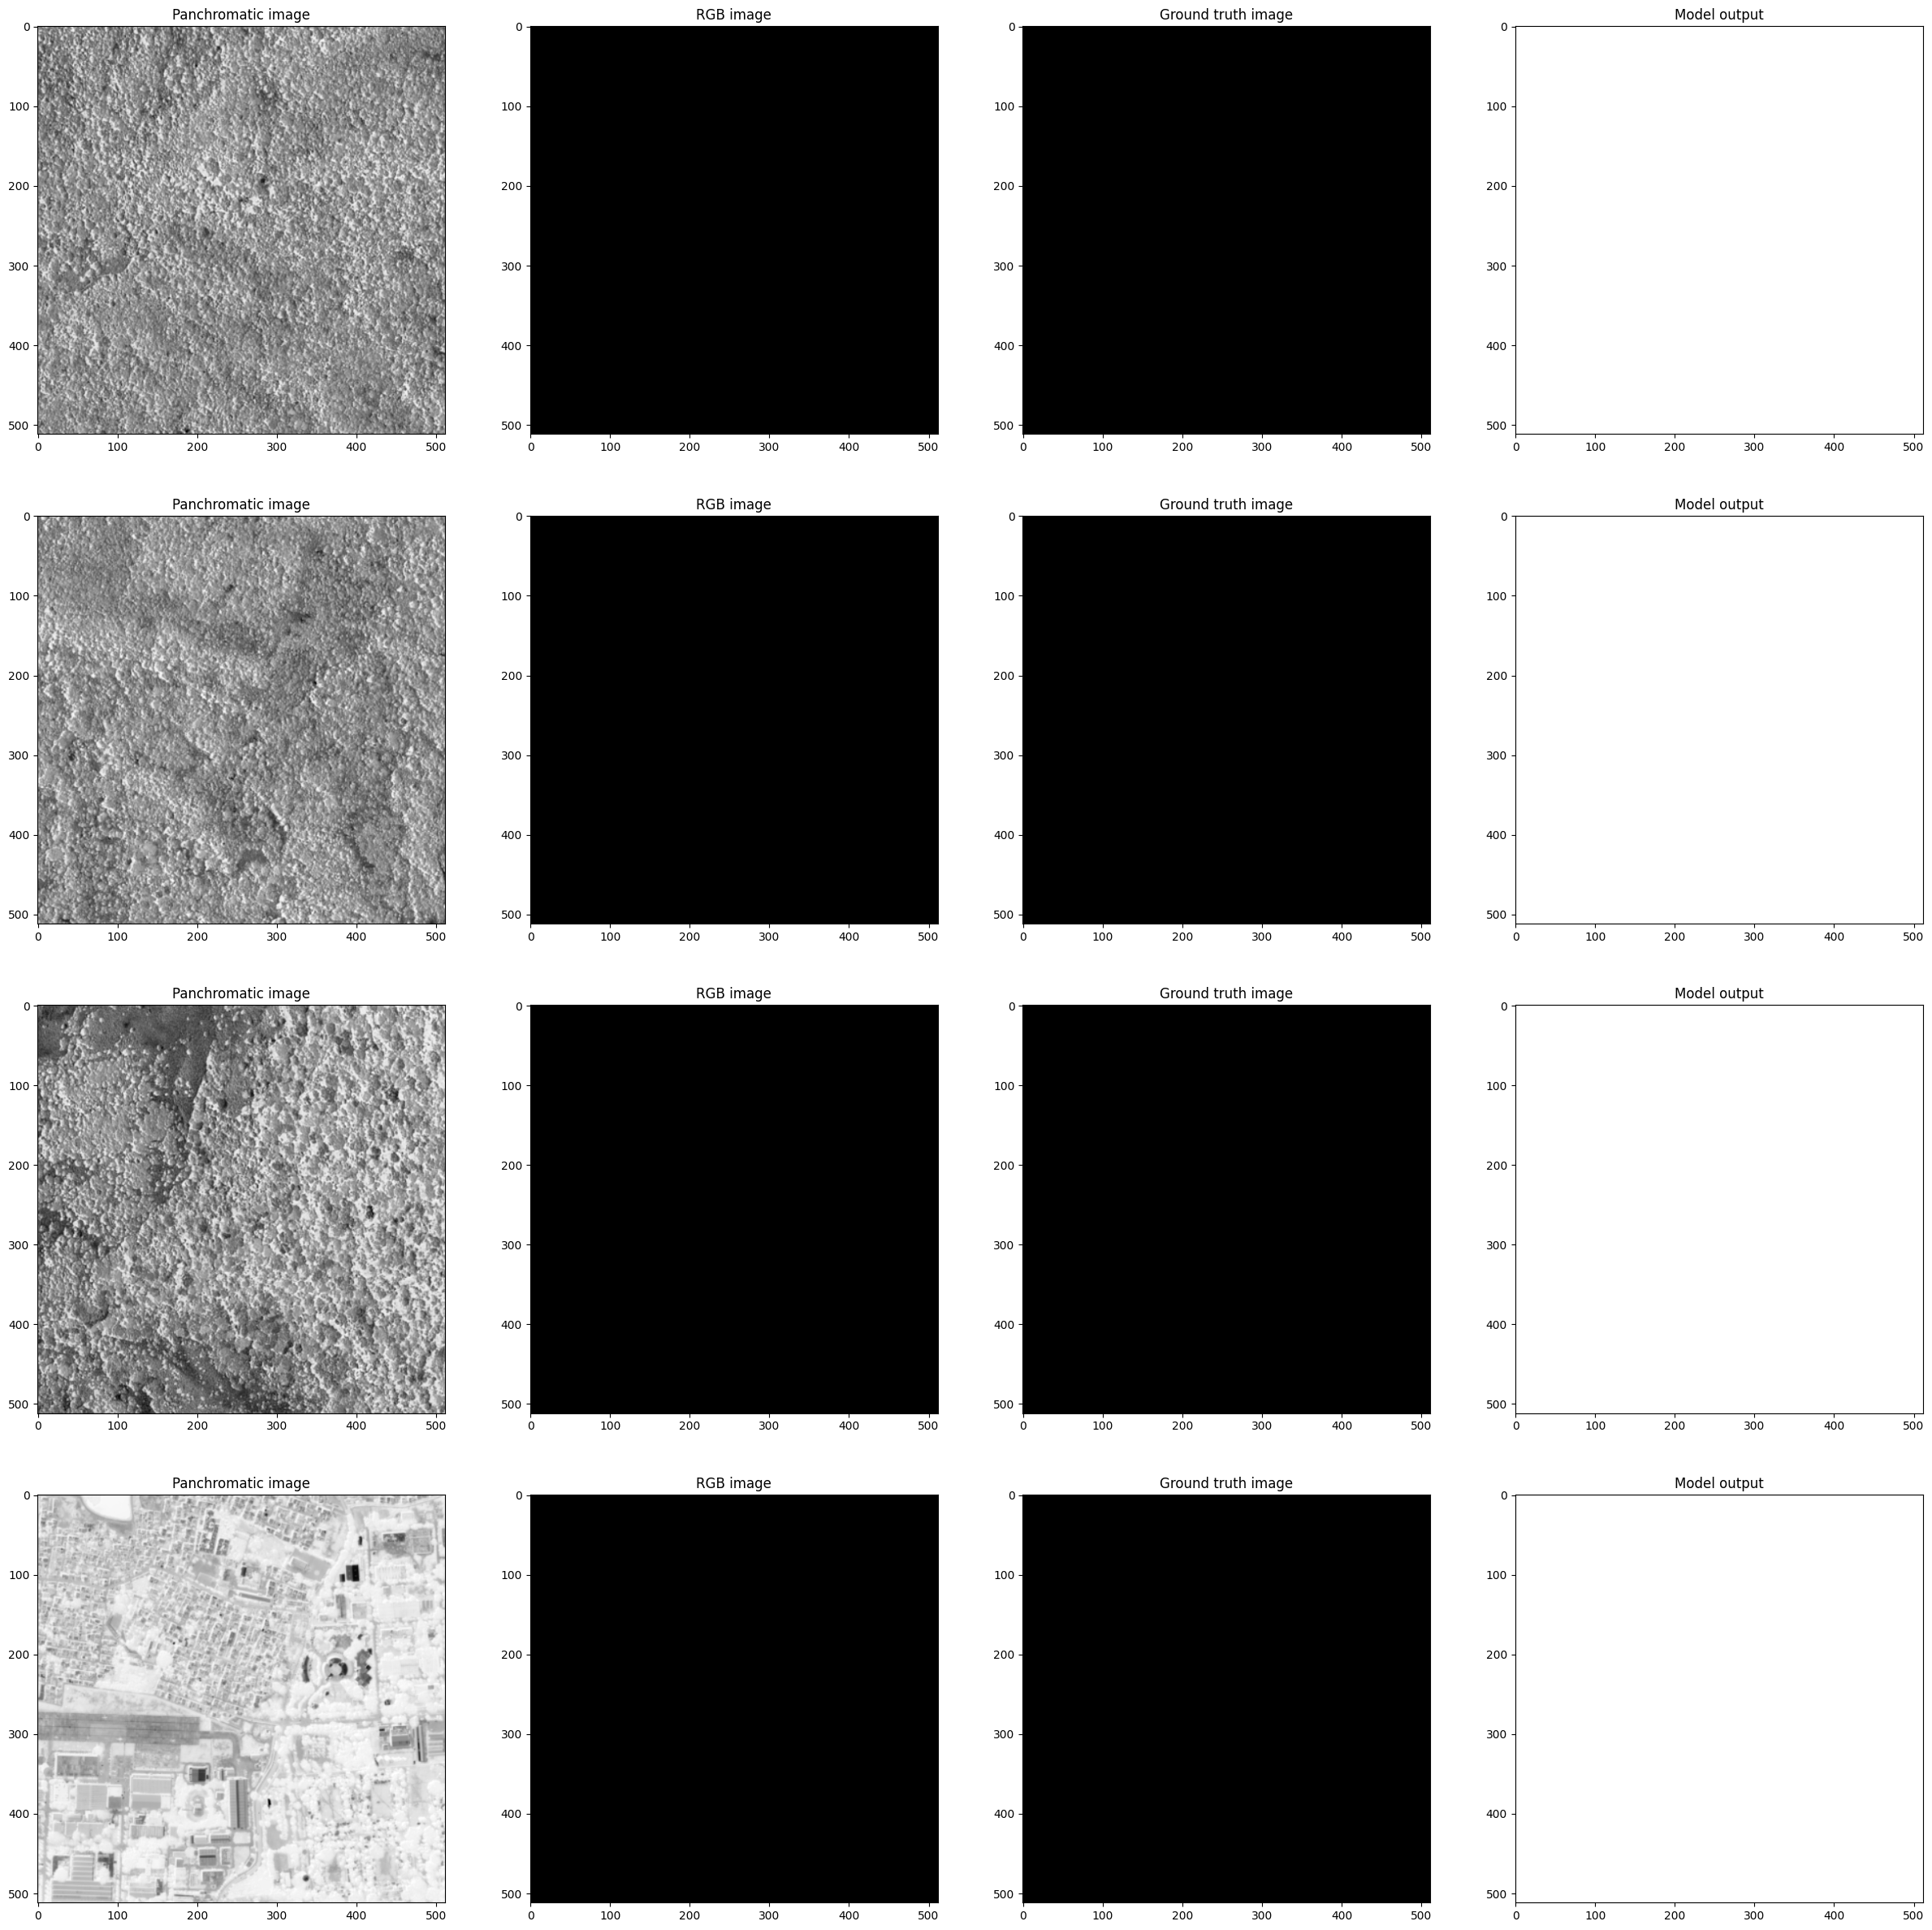

In [8]:
plt.figure(figsize=(30, 30))

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        if x.size()[2] != 512:
            x = util.imgs_resize(x.cpu(), 512).to(device)
            y = util.imgs_resize(y.cpu(), 512).to(device)
                                
        outputs = pix2pix(x)
        x, y, outputs = x.to("cpu").numpy(), y.to("cpu").numpy(), outputs.to("cpu").numpy()
        
        i = 0
        for input_imgs, sharp, output in zip(x, y, outputs):
            
            input_imgs = input_imgs.transpose((1, 2, 0))
            sharp = sharp.transpose((1, 2, 0))
            output = output.transpose((1, 2, 0))

            pan = input_imgs[:, :, 0]
            rgb = input_imgs[:, :, 1:]
    
            plt.subplot(batch_size, 4, i + 1)
            plt.imshow(pan / np.amax(pan), cmap="gray")
            plt.title("Panchromatic image")

            plt.subplot(batch_size, 4, i + 2)
            plt.imshow(rgb / np.amax(rgb))
            plt.title("RGB image")

            plt.subplot(batch_size, 4, i + 3)
            print(np.amax(sharp))
            plt.imshow(sharp / np.amax(sharp))
            plt.title("Ground truth image")

            plt.subplot(batch_size, 4, i + 4)
            print(np.amax(output))
            plt.imshow(output / np.amax(output))
            plt.title("Model output")

            i += 4
        
        break

In [ ]:
plt.figure(figsize=(30, 30))

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        
        if x.size()[2] != 512:
            x = util.imgs_resize(x.cpu(), 512).to(device)
            y = util.imgs_resize(y.cpu(), 512).to(device)
        
        outputs = pix2pix(x)
        x, y, outputs = x.to("cpu").numpy(), y.to("cpu").numpy(), outputs.to("cpu").numpy()
        
        i = 0
        for input_imgs, sharp, output in zip(x, y, outputs):
            
            input_imgs = input_imgs.transpose((1, 2, 0))
            sharp = sharp.transpose((1, 2, 0))
            output = output.transpose((1, 2, 0))

            pan = input_imgs[:, :, 0]
            rgb = input_imgs[:, :, 1:]

            plt.subplot(1, 4, i + 1)
            print(np.amax(output))
            plt.imshow((output - sharp) / np.amax(output - sharp))
            plt.title("Model output - truth")

            i += 1
        
        break

In [ ]:
print(evaluate_model_all_metrics(net=pix2pix, data_loader=val_loader))

In [ ]:
print(evaluate_pansharpening(path_to_val_sharp, algorithm=get_benchmark, train=False, train_perc=train_perc))